In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import cv2

# Konfigurasi Path
base_dir = 'data' 
img_height, img_width = 224, 224
batch_size = 32

# DEFINISI KELAS (Hanya 3 ini yang akan diambil, sisanya diabaikan)
classes = ['Normal', 'Pneumonia', 'Tuberculosis']

print(f"Konfigurasi Selesai. Target Kelas: {classes}")

Konfigurasi Selesai. Target Kelas: ['Normal', 'Pneumonia', 'Tuberculosis']


--- Distribusi Data (3 Kelas) ---
Normal: 1118 images
Pneumonia: 1246 images
Tuberculosis: 700 images


C:\Users\user\AppData\Local\Temp\ipykernel_23056\534517893.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data_counts.keys()), y=list(data_counts.values()), palette='viridis')


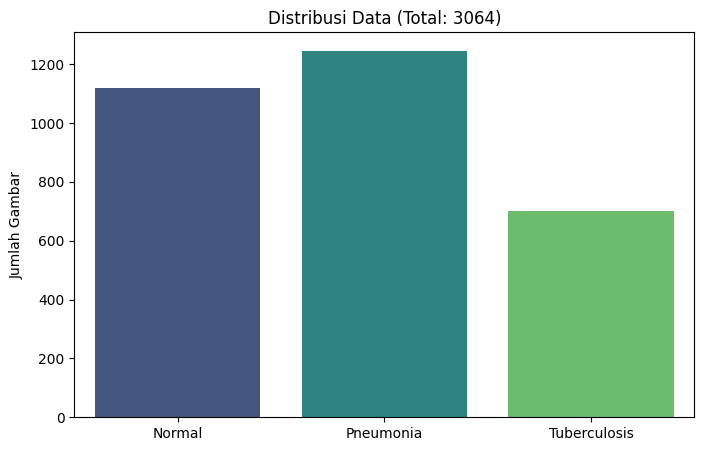

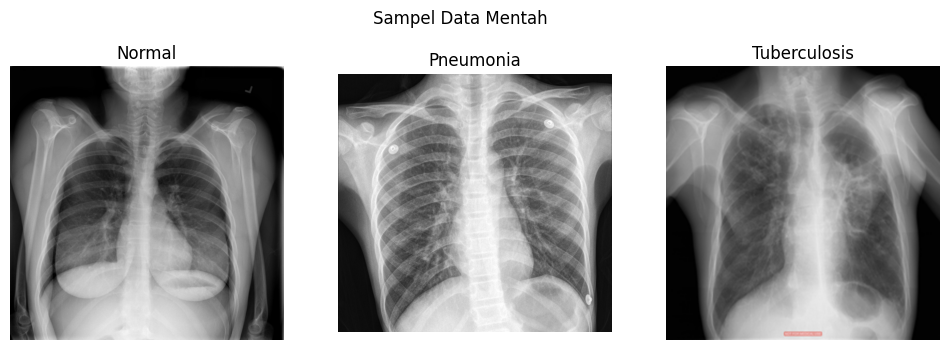

In [ ]:
# Menghitung jumlah gambar per kelas
data_counts = {}
total_images = 0

print("--- Distribusi Data (3 Kelas) ---")
for category in classes:
    folder_path = os.path.join(base_dir, category)
    if os.path.exists(folder_path):
        count = len(os.listdir(folder_path))
        data_counts[category] = count
        total_images += count
        print(f"{category}: {count} images")
    else:
        print(f"Warning: Folder {category} tidak ditemukan! Cek nama folder.")

# Visualisasi Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x=list(data_counts.keys()), y=list(data_counts.values()), palette='viridis')
plt.title(f'Distribusi Data (Total: {total_images})')
plt.ylabel('Jumlah Gambar')
plt.show()

# Menampilkan Sampel Gambar
plt.figure(figsize=(12, 4))
for i, category in enumerate(classes):
    folder_path = os.path.join(base_dir, category)
    if os.path.exists(folder_path):
        # Ambil gambar acak biar variatif
        img_name = np.random.choice(os.listdir(folder_path))
        img_path = os.path.join(folder_path, img_name)
        img = plt.imread(img_path)
        
        plt.subplot(1, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis('off')
plt.suptitle("Sampel Data Mentah")
plt.show()

In [3]:
# Setup Generator dengan Augmentasi
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Wajib untuk EfficientNet
    rotation_range=15,       
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    zoom_range=0.2,          
    horizontal_flip=True,    
    fill_mode='nearest',
    validation_split=0.2     # Split 80:20
)

print("Loading Training Data (80%):")
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=classes, # FILTER KELAS DISINI
    shuffle=True
)

print("Loading Validation Data (20%):")
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=classes, # FILTER KELAS DISINI
    shuffle=False
)

Loading Training Data (80%):
Found 2452 images belonging to 3 classes.
Loading Validation Data (20%):
Found 612 images belonging to 3 classes.


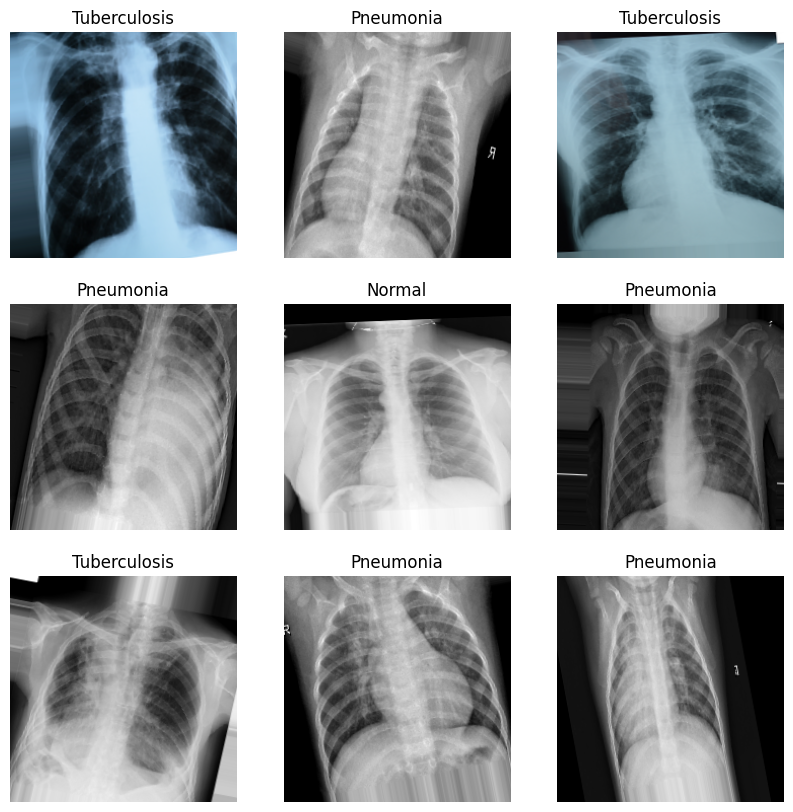

In [9]:
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img_disp = (x_batch[i] - x_batch[i].min()) / (x_batch[i].max() - x_batch[i].min()) # Rescale for view
    plt.imshow(img_disp)
    label_index = np.argmax(y_batch[i])
    plt.title(classes[label_index])
    plt.axis('off')
plt.show()

In [10]:
# 1. Load Base Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False # Bekukan dulu

# 2. Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x) 
# Output layer (Jumlah neuron sesuai len(classes) = 3)
predictions = Dense(len(classes), activation='softmax')(x)

# 3. Gabungkan
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,383,398 (16.72 MB)

 Trainable params: 331,267 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [11]:
# Callbacks
checkpoint = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

print("--- Training Tahap 1 (Head Only) ---")
history = model.fit(
    train_generator,
    epochs=10, 
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr]
)

--- Training Tahap 1 (Head Only) ---
Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9339 - loss: 0.1865 - val_accuracy: 0.8660 - val_loss: 0.2630 - learning_rate: 0.0010
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9731 - loss: 0.0861 - val_accuracy: 0.9510 - val_loss: 0.1281 - learning_rate: 0.0010
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9759 - loss: 0.0650 - val_accuracy: 0.9706 - val_loss: 0.0929 - learning_rate: 0.0010
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9792 - loss: 0.0596 - val_accuracy: 0.9886 - val_loss: 0.0406 - learning_rate: 0.0010
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9833 - loss: 0.0512 - val_accuracy: 0.9788 - val_loss: 0.0586 - learning_rate: 0.0010
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9821 - loss: 0.0612 - val_accuracy: 0.9837 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accura

In [ ]:
# Unfreeze base model
base_model.trainable = True

# Freeze layer awal, unfreeze 30 layer terakhir (biar lebih dalam belajarnya)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compile ulang dengan LR KECIL
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("--- Training Tahap 2 (Fine Tuning) ---")
history_fine = model.fit(
    train_generator,
    epochs=5, 
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr]
)

--- Training Tahap 2 (Fine Tuning) ---
Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9519 - loss: 0.1441 - val_accuracy: 0.9984 - val_loss: 0.0163 - learning_rate: 1.0000e-05
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9568 - loss: 0.1268 - val_accuracy: 0.9869 - val_loss: 0.0296 - learning_rate: 1.0000e-05
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9675 - loss: 0.0921
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
77/77 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9694 - loss: 0.0930 - val_accuracy: 0.9820 - val_loss: 0.0371 - learning_rate: 1.0000e-05
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9755 - loss: 0.0802 - val_accuracy: 0.9935 - val_loss: 0.0275 - learning_rate: 2.0000e-06
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9719 - loss: 0.0752 - val_accuracy: 0.9837 - val_loss: 0.0584 - learning_rate: 2.0000e-06
Epoch 5: early stopping
Restoring model we

20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       223
   Pneumonia       1.00      1.00      1.00       249
Tuberculosis       0.99      0.96      0.98       140

    accuracy                           0.99       612
   macro avg       0.99      0.99      0.99       612
weighted avg       0.99      0.99      0.99       612



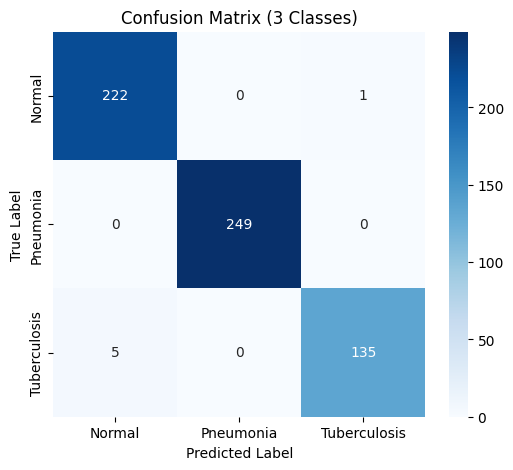

In [13]:
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation_generator.classes, y_pred, target_names=classes))

cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (3 Classes)')
plt.show()

--- Prediksi pada Data Baru (Unseen Data) ---


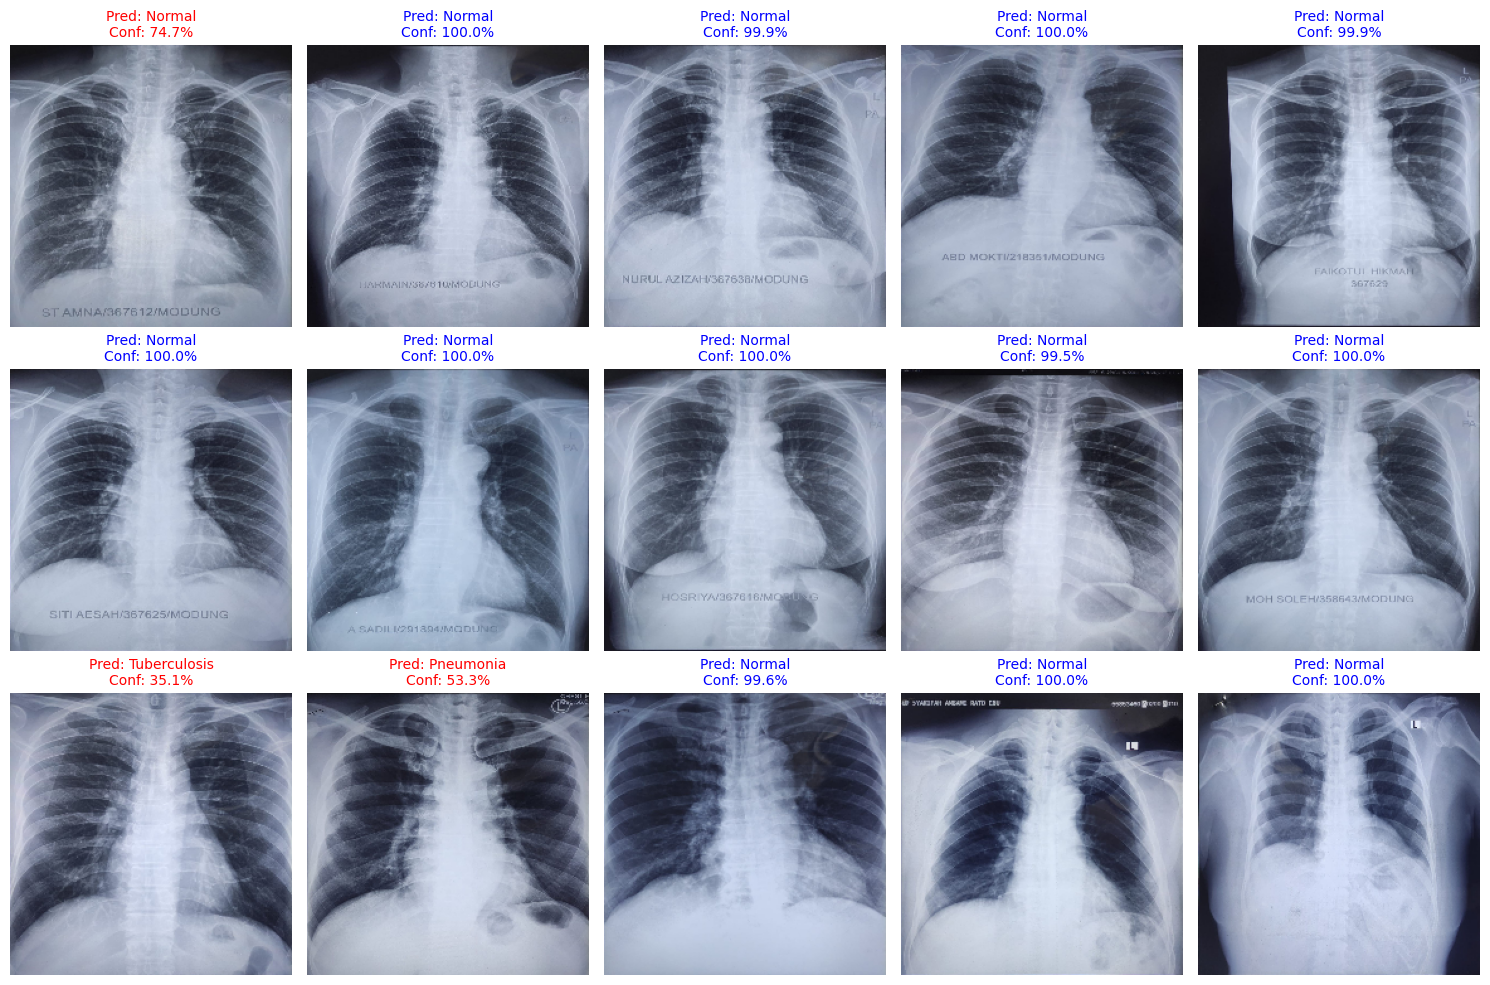

In [ ]:
from tensorflow.keras.preprocessing import image

# Path ke folder data_test
test_folder = os.path.join(base_dir, 'data_test')

# Cek apakah folder ada isinya
if os.path.exists(test_folder):
    test_images = os.listdir(test_folder)
    # Ambil 15 sampel acak jika gambar lebih dari 15
    if len(test_images) > 15:
        test_images = np.random.choice(test_images, 15, replace=False)
    
    plt.figure(figsize=(15, 10))
    print("--- Prediksi pada Data Baru (Unseen Data) ---")

    for i, img_name in enumerate(test_images):
        img_path = os.path.join(test_folder, img_name)
        
        # Load & Preprocess
        try:
            img_org = image.load_img(img_path, target_size=(img_height, img_width))
            x = image.img_to_array(img_org)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            
            # Predict
            classes_pred = model.predict(x, verbose=0)
            predicted_class = classes[np.argmax(classes_pred)]
            confidence = np.max(classes_pred) * 100
            
            # Tampilkan
            plt.subplot(3, 5, i+1)
            plt.imshow(img_org)
            plt.title(f"Pred: {predicted_class}\nConf: {confidence:.1f}%", 
                      color='blue' if confidence > 80 else 'red', fontsize=10)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

    plt.tight_layout()
    plt.show()
else:
    print("Folder data_test tidak ditemukan.")

--- Evaluasi Data Test Real (15 Sampel) ---


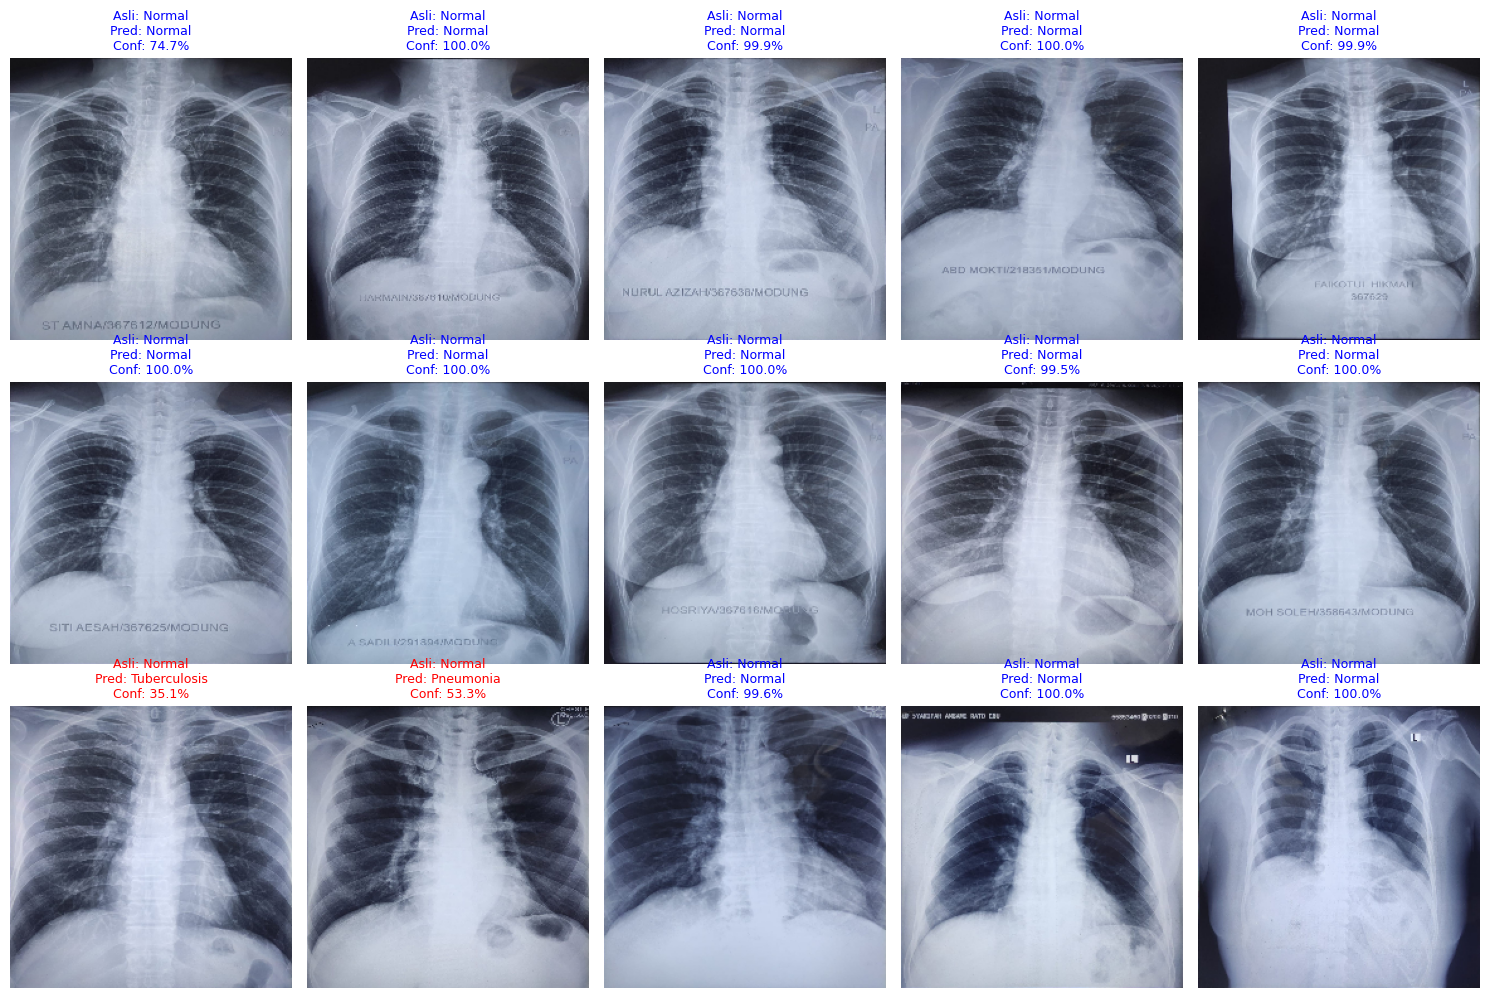


HASIL EVALUASI DATA TEST (RSUD)
Akurasi Total: 86.67%

Detail Report:
              precision    recall  f1-score   support

      Normal       1.00      0.87      0.93        15
   Pneumonia       0.00      0.00      0.00         0
Tuberculosis       0.00      0.00      0.00         0

    accuracy                           0.87        15
   macro avg       0.33      0.29      0.31        15
weighted avg       1.00      0.87      0.93        15



C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

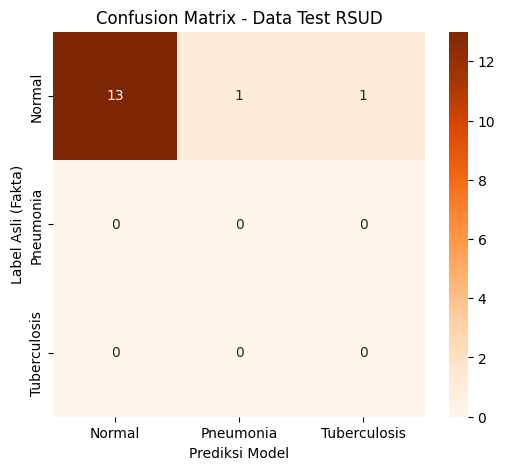

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import pandas as pd

# 1. DEFINISI LABEL (Sesuaikan urutan 'classes' di model kamu)
# Pastikan urutannya SAMA PERSIS dengan saat training!
# Contoh: classes = ['Normal', 'Pneumonia', 'Tuberculosis']
class_map = {0: 'Normal', 1: 'Pneumonia', 2: 'Tuberculosis'}

# Path ke folder data_test
test_folder = os.path.join(base_dir, 'data_test')

if os.path.exists(test_folder):
    # Ambil semua file dan SORTIR (biar urutannya konsisten, jangan random)
    test_images = sorted(os.listdir(test_folder))
    
    # Ambil 15 data saja (jika mau membatasi)
    test_images = test_images[:15] 

    # List penampung
    y_true = [] # Label Asli (Kunci Jawaban)
    y_pred = [] # Label Prediksi Model
    
    plt.figure(figsize=(15, 10))
    print(f"--- Evaluasi Data Test Real ({len(test_images)} Sampel) ---")

    for i, img_name in enumerate(test_images):
        img_path = os.path.join(test_folder, img_name)
        
        # --- LANGKAH 1: TENTUKAN LABEL ASLI (GROUND TRUTH) ---
        # Logika: Deteksi dari nama file. 
        # Misal nama file: "pasien_tb_01.jpg" -> mengandung "tb" -> Label Tuberculosis
        
        fname = img_name.lower()
        if 'norm' in fname:
            actual_idx = 0 # Normal
        elif 'pneu' in fname:
            actual_idx = 1 # Pneumonia
        elif 'tb' in fname or 'tuber' in fname:
            actual_idx = 2 # Tuberculosis
        else:
            # Jika nama file tidak jelas, anggap labelnya -1 (unknown) atau set manual
            actual_idx = 0 # Default (Hati-hati disini!)
            print(f"Warning: Label asli {img_name} tidak terdeteksi otomatis, dianggap Normal.")

        y_true.append(actual_idx)

        # --- LANGKAH 2: PREDIKSI MODEL ---
        try:
            # Load & Preprocess (WAJIB SAMA DENGAN TRAINING)
            img_org = image.load_img(img_path, target_size=(img_height, img_width))
            x = image.img_to_array(img_org)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x) # Normalisasi EfficientNet
            
            # Predict
            classes_pred = model.predict(x, verbose=0)
            pred_idx = np.argmax(classes_pred) # Dapat angka index (0/1/2)
            y_pred.append(pred_idx)
            
            confidence = np.max(classes_pred) * 100
            
            # --- LANGKAH 3: VISUALISASI GAMBAR ---
            plt.subplot(3, 5, i+1)
            plt.imshow(img_org)
            
            # Cek Benar/Salah untuk warna teks
            is_correct = (actual_idx == pred_idx)
            color_text = 'blue' if is_correct else 'red'
            
            label_asli_txt = class_map[actual_idx]
            label_pred_txt = class_map[pred_idx]
            
            plt.title(f"Asli: {label_asli_txt}\nPred: {label_pred_txt}\nConf: {confidence:.1f}%", 
                      color=color_text, fontsize=9)
            plt.axis('off')
            
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

    plt.tight_layout()
    plt.show()

    # --- LANGKAH 4: GENERATE CONFUSION MATRIX & REPORT ---
    
    print("\n" + "="*40)
    print("HASIL EVALUASI DATA TEST (RSUD)")
    print("="*40)
    
    # Hitung Akurasi
    acc = accuracy_score(y_true, y_pred)
    print(f"Akurasi Total: {acc*100:.2f}%")
    
    # Classification Report
    print("\nDetail Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Label Asli (Fakta)')
    plt.title('Confusion Matrix - Data Test RSUD')
    plt.show()

else:
    print("Folder data_test tidak ditemukan.")